In [8]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 25.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from collections import Counter
import nltk
from datasets import load_dataset


try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except nltk.downloader.DownloadError:
    nltk.download('averaged_perceptron_tagger', quiet=True)






In [10]:
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



try:
    dataset = load_dataset("imdb")
    print("Successfully loaded imdb dataset.")
except Exception as e:
    print(f"Failed to load imdb dataset. Error: {e}")
    dataset_dict = {
        "train": [{"text": "This is a good movie.", "label": 1}, {"text": "What a terrible film.", "label": 0}] * 50,
        "test": [{"text": "An okay picture.", "label": 1}, {"text": "Not recommended.", "label": 0}] * 20
    }
    from datasets import Dataset as HFDataset, DatasetDict
    train_ds = HFDataset.from_dict({k: [d[k] for d in dataset_dict['train']] for k in dataset_dict['train'][0]})
    test_ds = HFDataset.from_dict({k: [d[k] for d in dataset_dict['test']] for k in dataset_dict['test'][0]})
    dataset = DatasetDict({'train': train_ds, 'test': test_ds})
    print("Loaded a tiny DUMMY dataset as a fallback.")




Libraries imported successfully!
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Successfully loaded imdb dataset.


In [11]:
N_TRAIN_SAMPLES = 1000
N_TEST_SAMPLES = 200


train_val_full = dataset["train"].shuffle(seed=42)
test_full = dataset["test"].shuffle(seed=42)

train_val_subset = train_val_full.select(range(min(N_TRAIN_SAMPLES, len(train_val_full))))
test_subset = test_full.select(range(min(N_TEST_SAMPLES, len(test_full))))


train_val_split = train_val_subset.train_test_split(test_size=0.15, seed=42)
train_data = train_val_split['train']
val_data = train_val_split['test']
test_data = test_subset

print(f"Dataset loaded! Training examples: {len(train_data)}, Validation examples: {len(val_data)}, Test examples: {len(test_data)}")




Dataset loaded! Training examples: 850, Validation examples: 150, Test examples: 200


In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
def tokenize_and_tag_texts(data_split, name="data"):
    texts = [example['text'] for example in data_split]
    tokenized_texts_list = []
    pos_tags_for_texts_list = []

    print(f"Tokenizing and POS tagging for {len(texts)} examples in '{name}' split...")
    for text in tqdm(texts, desc=f"Processing {name}"):
        tokens = nltk.word_tokenize(text.lower())
        tokens = [token for token in tokens if token.strip()]
        if not tokens: tokens = ["<UNK_WORD>"]

        pos_tags_tuples = nltk.pos_tag(tokens)
        pos_tags = [tag for token, tag in pos_tags_tuples]
        if len(pos_tags) != len(tokens):
            pos_tags = ["X"] * len(tokens)

        tokenized_texts_list.append(tokens)
        pos_tags_for_texts_list.append(pos_tags)

    return tokenized_texts_list, pos_tags_for_texts_list

train_tokens_list, train_tags_list = tokenize_and_tag_texts(train_data, "train")
val_tokens_list, val_tags_list = tokenize_and_tag_texts(val_data, "validation")
test_tokens_list, test_tags_list = tokenize_and_tag_texts(test_data, "test")

if train_tokens_list:
    print(f"\nSample tokens (first 10 from first training example): {train_tokens_list[0][:10]}")
    print(f"Sample POS tags (first 10 from first training example): {train_tags_list[0][:10]}")



Tokenizing and POS tagging for 850 examples in 'train' split...


Processing train:   0%|          | 0/850 [00:00<?, ?it/s]

Tokenizing and POS tagging for 150 examples in 'validation' split...


Processing validation:   0%|          | 0/150 [00:00<?, ?it/s]

Tokenizing and POS tagging for 200 examples in 'test' split...


Processing test:   0%|          | 0/200 [00:00<?, ?it/s]


Sample tokens (first 10 from first training example): ['this', 'film', 'evil', 'breed', ':', 'the', 'legend', 'of', 'samhain', 'contains']
Sample POS tags (first 10 from first training example): ['DT', 'NN', 'JJ', 'NN', ':', 'DT', 'NN', 'IN', 'NN', 'NNS']


Word vocabulary created with 15000 words.

POS Tag vocabulary created with 44 tags.
Tag mapping (sample): [('<PAD_TAG>', 0), ('$', 1), ("''", 2), ('(', 3), (')', 4)]...
PAD_IDX_WORD: 0, PAD_TAG_IDX for labels: 0


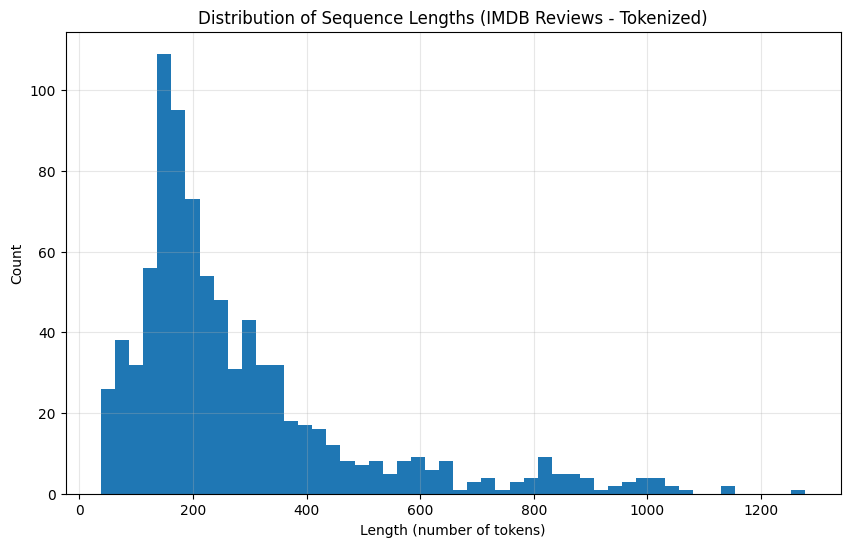

Chosen MAX_LEN based on 98th percentile: 942


Encoding train tokens:   0%|          | 0/850 [00:00<?, ?it/s]

Encoding train tags:   0%|          | 0/850 [00:00<?, ?it/s]

Encoding val tokens:   0%|          | 0/150 [00:00<?, ?it/s]

Encoding val tags:   0%|          | 0/150 [00:00<?, ?it/s]

Encoding test tokens:   0%|          | 0/200 [00:00<?, ?it/s]

Encoding test tags:   0%|          | 0/200 [00:00<?, ?it/s]


Data encoding complete! Example token sequence: tensor([  17,   26,  377, 8675,   91,    2, 2103,    7, 4518, 1238,   66,  124,
         206,   50,  620])...
Example tag sequence: tensor([10, 18, 14, 18,  7, 10, 18, 13, 18, 21, 26, 14, 18,  8, 18])...
DataLoaders created! Training batches: 27
SequenceTaggerLSTM model (N_LAYERS=1) created and moved to cuda!
SequenceTaggerLSTM(
  (embedding): Embedding(15000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=44, bias=True)
)
The model has 1,746,828 trainable parameters
Loss function (CrossEntropyLoss with ignore_index=0) and optimizer defined!
Starting training for 10 epochs...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 1/10 | SAVED best model with val_loss: 2.2664
	Train Loss: 3.097 | Train Acc (token-level): 31.06%
	Val. Loss: 2.266 |  Val. Acc (token-level): 49.25%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 2/10 | SAVED best model with val_loss: 1.5750
	Train Loss: 2.032 | Train Acc (token-level): 49.27%
	Val. Loss: 1.575 |  Val. Acc (token-level): 56.64%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 3/10 | SAVED best model with val_loss: 1.1647
	Train Loss: 1.530 | Train Acc (token-level): 58.39%
	Val. Loss: 1.165 |  Val. Acc (token-level): 67.08%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 4/10 | SAVED best model with val_loss: 0.9257
	Train Loss: 1.234 | Train Acc (token-level): 65.94%
	Val. Loss: 0.926 |  Val. Acc (token-level): 73.09%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 5/10 | SAVED best model with val_loss: 0.7780
	Train Loss: 1.045 | Train Acc (token-level): 70.55%
	Val. Loss: 0.778 |  Val. Acc (token-level): 77.12%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 6/10 | SAVED best model with val_loss: 0.6822
	Train Loss: 0.917 | Train Acc (token-level): 73.73%
	Val. Loss: 0.682 |  Val. Acc (token-level): 79.41%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 7/10 | SAVED best model with val_loss: 0.6102
	Train Loss: 0.825 | Train Acc (token-level): 76.09%
	Val. Loss: 0.610 |  Val. Acc (token-level): 81.46%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 8/10 | SAVED best model with val_loss: 0.5558
	Train Loss: 0.756 | Train Acc (token-level): 77.93%
	Val. Loss: 0.556 |  Val. Acc (token-level): 82.81%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 9/10 | SAVED best model with val_loss: 0.5190
	Train Loss: 0.700 | Train Acc (token-level): 79.31%
	Val. Loss: 0.519 |  Val. Acc (token-level): 83.86%


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 10/10 | SAVED best model with val_loss: 0.4879
	Train Loss: 0.656 | Train Acc (token-level): 80.54%
	Val. Loss: 0.488 |  Val. Acc (token-level): 84.82%

Training complete!


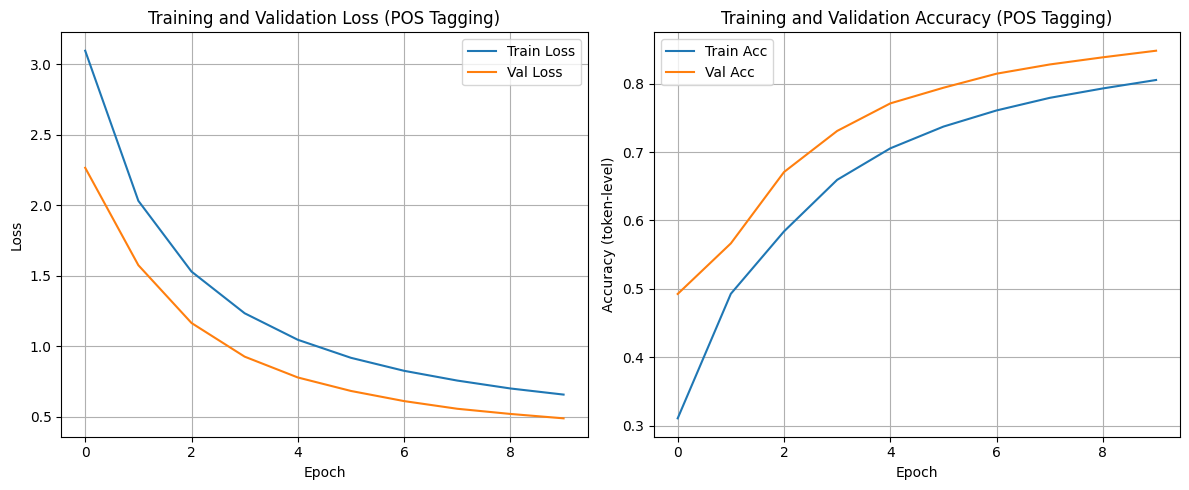

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


Test Loss: 0.478 | Test Acc (token-level): 85.12%


In [15]:

word_counts = Counter()
for sentence_tokens in train_tokens_list:
    word_counts.update(sentence_tokens)

PAD_TOKEN = "<PAD_WORD>"
UNK_TOKEN = "<UNK_WORD>"
VOCAB_MAX_SIZE = 15000

most_common_words = word_counts.most_common(VOCAB_MAX_SIZE - 2)
word_to_idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common_words)}
word_to_idx[PAD_TOKEN] = 0
word_to_idx[UNK_TOKEN] = 1
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)
PAD_IDX_WORD = word_to_idx[PAD_TOKEN]

print(f"Word vocabulary created with {vocab_size} words.")


tag_counts = Counter()
for sentence_tags in train_tags_list:
    tag_counts.update(sentence_tags)

PAD_TAG = "<PAD_TAG>"


unique_tags_from_train = sorted(list(tag_counts.keys()))

if PAD_TAG in unique_tags_from_train:
    unique_tags_from_train.remove(PAD_TAG)
final_unique_tags = [PAD_TAG] + unique_tags_from_train

tag_to_idx = {tag: idx for idx, tag in enumerate(final_unique_tags)}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
output_dim_tags = len(tag_to_idx)
PAD_TAG_IDX = tag_to_idx[PAD_TAG]

print(f"\nPOS Tag vocabulary created with {output_dim_tags} tags.")
print(f"Tag mapping (sample): {list(tag_to_idx.items())[:5]}...")
print(f"PAD_IDX_WORD: {PAD_IDX_WORD}, PAD_TAG_IDX for labels: {PAD_TAG_IDX}")
assert PAD_TAG_IDX == 0, "PAD_TAG_IDX must be 0 for CrossEntropyLoss ignore_index to work correctly."


seq_lengths = [len(tokens) for tokens in train_tokens_list]
if not seq_lengths: seq_lengths = [100]

plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50)
plt.title("Distribution of Sequence Lengths (IMDB Reviews - Tokenized)")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

MAX_LEN = int(np.percentile(seq_lengths, 98)) if seq_lengths else 200
print(f"Chosen MAX_LEN based on 98th percentile: {MAX_LEN}")
MAX_LEN = max(1, MAX_LEN)

def encode_tokens_fn(tokens, word_map, max_len_val):
    encoded = [word_map.get(token, word_map[UNK_TOKEN]) for token in tokens[:max_len_val]]
    padding_length = max_len_val - len(encoded)
    encoded.extend([PAD_IDX_WORD] * padding_length)
    return encoded

def encode_tags_fn(tags, tag_map, max_len_val):
    encoded = [tag_map.get(tag, tag_map[PAD_TAG]) for tag in tags[:max_len_val]] # Map unknown tags to PAD_TAG
    padding_length = max_len_val - len(encoded)
    encoded.extend([PAD_TAG_IDX] * padding_length)
    return encoded

train_encoded_tokens = [encode_tokens_fn(tokens, word_to_idx, MAX_LEN) for tokens in tqdm(train_tokens_list, desc="Encoding train tokens")]
train_encoded_tags = [encode_tags_fn(tags, tag_to_idx, MAX_LEN) for tags in tqdm(train_tags_list, desc="Encoding train tags")]

val_encoded_tokens = [encode_tokens_fn(tokens, word_to_idx, MAX_LEN) for tokens in tqdm(val_tokens_list, desc="Encoding val tokens")]
val_encoded_tags = [encode_tags_fn(tags, tag_to_idx, MAX_LEN) for tags in tqdm(val_tags_list, desc="Encoding val tags")]

test_encoded_tokens = [encode_tokens_fn(tokens, word_to_idx, MAX_LEN) for tokens in tqdm(test_tokens_list, desc="Encoding test tokens")]
test_encoded_tags = [encode_tags_fn(tags, tag_to_idx, MAX_LEN) for tags in tqdm(test_tags_list, desc="Encoding test tags")]


def to_tensor_safe(data_list, max_len_val):
    if data_list:
        return torch.tensor(data_list, dtype=torch.long)
    return torch.empty((0, max_len_val), dtype=torch.long)

train_sequences_tensor = to_tensor_safe(train_encoded_tokens, MAX_LEN)
train_labels_tensor = to_tensor_safe(train_encoded_tags, MAX_LEN)

val_sequences_tensor = to_tensor_safe(val_encoded_tokens, MAX_LEN)
val_labels_tensor = to_tensor_safe(val_encoded_tags, MAX_LEN)

test_sequences_tensor = to_tensor_safe(test_encoded_tokens, MAX_LEN)
test_labels_tensor = to_tensor_safe(test_encoded_tags, MAX_LEN)

if train_sequences_tensor.numel() > 0:
    print(f"\nData encoding complete! Example token sequence: {train_sequences_tensor[0][:15]}...")
    print(f"Example tag sequence: {train_labels_tensor[0][:15]}...")


class SequenceTaggingDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = SequenceTaggingDataset(train_sequences_tensor, train_labels_tensor) if train_sequences_tensor.numel() > 0 else []
val_dataset = SequenceTaggingDataset(val_sequences_tensor, val_labels_tensor) if val_sequences_tensor.numel() > 0 else []
test_dataset = SequenceTaggingDataset(test_sequences_tensor, test_labels_tensor) if test_sequences_tensor.numel() > 0 else []

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) if train_dataset else None
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE) if val_dataset else None
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE) if test_dataset else None

if train_loader:
    print(f"DataLoaders created! Training batches: {len(train_loader)}")


class SequenceTaggerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers=1, bidirectional=True, dropout_rate=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout_rate if n_layers > 1 else 0,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, text_seq):
        embedded = self.dropout(self.embedding(text_seq))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out_dropout = self.dropout(lstm_out)
        predictions = self.fc(lstm_out_dropout)
        return predictions


EMBEDDING_DIM_MODEL = 100
HIDDEN_DIM_MODEL = 128
N_LAYERS_MODEL = 1
BIDIRECTIONAL_MODEL = True
DROPOUT_MODEL = 0.4

model = SequenceTaggerLSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM_MODEL,
    hidden_dim=HIDDEN_DIM_MODEL,
    output_dim=output_dim_tags,
    n_layers=N_LAYERS_MODEL,
    bidirectional=BIDIRECTIONAL_MODEL,
    dropout_rate=DROPOUT_MODEL,
    pad_idx=PAD_IDX_WORD
)
model = model.to(device)

print(f"SequenceTaggerLSTM model (N_LAYERS={N_LAYERS_MODEL}) created and moved to {device}!")
print(model)

def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX)
criterion = criterion.to(device)
print(f"Loss function (CrossEntropyLoss with ignore_index={PAD_TAG_IDX}) and optimizer defined!")


def train_epoch_fn(model_to_train, iterator, optimizer_to_use, criterion_to_use, current_pad_tag_idx):
    model_to_train.train()
    epoch_loss = 0
    total_correct_preds = 0
    total_preds_count = 0
    if not iterator: return 0, 0

    for batch in tqdm(iterator, desc="Training", leave=False):
        tokens, tags = batch
        tokens, tags = tokens.to(device), tags.to(device)
        optimizer_to_use.zero_grad()
        predictions = model_to_train(tokens)
        predictions_reshaped = predictions.view(-1, predictions.shape[-1])
        tags_reshaped = tags.view(-1)
        loss = criterion_to_use(predictions_reshaped, tags_reshaped)
        predicted_classes = torch.argmax(predictions, dim=2)
        non_pad_mask = (tags != current_pad_tag_idx)
        correct_preds = (predicted_classes == tags) & non_pad_mask
        total_correct_preds += correct_preds.sum().item()
        total_preds_count += non_pad_mask.sum().item()
        loss.backward()
        optimizer_to_use.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(iterator) if len(iterator) > 0 else 0
    avg_acc = total_correct_preds / total_preds_count if total_preds_count > 0 else 0
    return avg_loss, avg_acc

def evaluate_epoch_fn(model_to_eval, iterator, criterion_to_use, current_pad_tag_idx):
    model_to_eval.eval()
    epoch_loss = 0
    total_correct_preds = 0
    total_preds_count = 0
    if not iterator: return 0, 0

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating", leave=False):
            tokens, tags = batch
            tokens, tags = tokens.to(device), tags.to(device)
            predictions = model_to_eval(tokens)
            predictions_reshaped = predictions.view(-1, predictions.shape[-1])
            tags_reshaped = tags.view(-1)
            loss = criterion_to_use(predictions_reshaped, tags_reshaped)
            predicted_classes = torch.argmax(predictions, dim=2)
            non_pad_mask = (tags != current_pad_tag_idx)
            correct_preds = (predicted_classes == tags) & non_pad_mask
            total_correct_preds += correct_preds.sum().item()
            total_preds_count += non_pad_mask.sum().item()
            epoch_loss += loss.item()
    avg_loss = epoch_loss / len(iterator) if len(iterator) > 0 else 0
    avg_acc = total_correct_preds / total_preds_count if total_preds_count > 0 else 0
    return avg_loss, avg_acc


N_EPOCHS_TRAIN = 10
best_valid_loss = float('inf')

train_losses_history = []
train_accs_history = []
val_losses_history = []
val_accs_history = []

if train_loader and val_loader:
    print(f"Starting training for {N_EPOCHS_TRAIN} epochs...")
    for epoch in range(N_EPOCHS_TRAIN):
        train_loss, train_acc = train_epoch_fn(model, train_loader, optimizer, criterion, PAD_TAG_IDX)
        valid_loss, valid_acc = evaluate_epoch_fn(model, val_loader, criterion, PAD_TAG_IDX)

        train_losses_history.append(train_loss)
        train_accs_history.append(train_acc)
        val_losses_history.append(valid_loss)
        val_accs_history.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'pos_tagging_lstm_imdb_model.pt')
            print(f"\tEpoch {epoch+1}/{N_EPOCHS_TRAIN} | SAVED best model with val_loss: {best_valid_loss:.4f}")
        else:
            print(f"\tEpoch {epoch+1}/{N_EPOCHS_TRAIN}")

        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc (token-level): {train_acc*100:.2f}%")
        print(f"\tVal. Loss: {valid_loss:.3f} |  Val. Acc (token-level): {valid_acc*100:.2f}%")
    print("\nTraining complete!")
else:
    print("Cannot start training: train_loader or val_loader is not available.")
if train_losses_history and val_losses_history:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_history, label='Train Loss')
    plt.plot(val_losses_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (POS Tagging)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs_history, label='Train Acc')
    plt.plot(val_accs_history, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (token-level)')
    plt.title('Training and Validation Accuracy (POS Tagging)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No data to plot. Training might not have run or completed successfully.")
if test_loader:
    model.load_state_dict(torch.load('pos_tagging_lstm_imdb_model.pt')) # Load best model
    test_loss, test_acc = evaluate_epoch_fn(model, test_loader, criterion, PAD_TAG_IDX)
    print(f'\nTest Loss: {test_loss:.3f} | Test Acc (token-level): {test_acc*100:.2f}%')
else:
    print("Test loader not available. Skipping test set evaluation.")

def predict_pos_tags(sentence, model_to_use, word_map, tag_map_rev, max_len_val):
    model_to_use.eval()
    tokens = nltk.word_tokenize(sentence.lower())
    tokens = [token for token in tokens if token.strip()]
    if not tokens: return []

    numericalized_tokens = [word_map.get(token, word_map[UNK_TOKEN]) for token in tokens]
    padded_numerical_tokens = numericalized_tokens[:max_len_val] + [PAD_IDX_WORD] * (max_len_val - len(numerical_tokens))

    sentence_tensor = torch.LongTensor([padded_numerical_tokens]).to(device)

    with torch.no_grad():
        predictions = model_to_use(sentence_tensor)

    top_predictions = predictions.argmax(dim=2)
    predicted_tags_indices = top_predictions[0].cpu().tolist()

    predicted_tags_strings = [tag_map_rev[idx] for idx in predicted_tags_indices[:len(tokens)]] # Only for original tokens

    return list(zip(tokens, predicted_tags_strings))

In [1]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True